In [ ]:
import numpy as np
import pandas as pd
import os, re

import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split

import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertConfig


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
df = pd.read_csv('negative_language.csv')
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 24,783



,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
790,805,6,0,6,0,1,#TjohnGang&#128520; lil bitch follow me ! http...
8830,9075,3,0,3,0,1,Don't worry bout me I got it all arranged bitc...
2261,2306,3,0,0,3,2,"5 bags of chips, 3 Rice Krispies, 3 seeds, 3 g..."
4038,4159,3,0,2,1,1,"@MarketWiseNick In many areas has that look, b..."
8356,8586,3,0,3,0,1,Can't stand ghetto ratchet ass mofos &#128078;...
8677,8918,3,0,3,0,1,Dear inconsiderate ghetto fuck on the train ac...
3560,3656,6,2,3,1,1,@JPantsdotcom @Todd__Kincannon @the__realtony ...
15413,15776,3,0,0,3,2,RT @HEGS_com: What's that bright yellow thing ...
1043,1066,3,1,2,0,1,&#128557;&#128557; RT @KingHov1313: Niggaz get...
1417,1447,3,0,3,0,1,&#8220;@MikeDiggEm: @_KudaBrazyy who the old b...


In the [class] collum: <br>
0 prefer to hate speech <br>
1 is offensive <br>
2 is neither

# Preprocessing

In [ ]:
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
print(df['tweet'][1])
strip_all_entities(df['tweet'][1])

!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!


'RT boy dats cold tyga dwn bad for cuffin dat hoe in the 1st place'

In [ ]:
if CLEAN_TWEETS == False:
    df['tweet']=df['tweet'].apply(strip_all_entities)

In [ ]:
sentences = df['tweet'].values
labels = df['class'].values

In [ ]:
train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

trn_sentences = train['tweet'].values
train_labels = train['class'].values

tst_sentences = test['tweet'].values
test_labels = test['class'].values

val_sentences = validation['tweet'].values
validation_labels = validation['class'].values

In [ ]:
# Tokenization
from transformers import BertTokenizer

print('loading Bert tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

loading Bert tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
enc_exp = tokenizer.encode('My name is Quan')
dec_exp = tokenizer.decode(enc_exp)
print(enc_exp)
print(dec_exp)

[101, 2026, 2171, 2003, 24110, 102]
[CLS] my name is quan [SEP]


In [ ]:
# Padding & Masking
print('Max array length: ', max([len(i) for i in sentences]))
count1, count2, count3 = 0, 0, 0
for i in sentences:
    if len(i)>100:
        count1+=1
    if len(i)>200:
        count2+=1
    if len(i)>300:
        count3+=1
print('number of array longer than 100: ', count1)
print('number of array longer than 200: ', count2)
print('number of array longer than 300: ', count3)

Max array length:  754
number of array longer than 100:  9033
number of array longer than 200:  86
number of array longer than 300:  16


In [ ]:
def bert_encode(data, max_len) :
    input_ids = []
    attention_masks = []


    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length = max_len,
                                        padding = 'max_length',
                                        truncation = True,
                                        return_attention_mask=True)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [ ]:
MAX_LEN = 64
train_inputs, train_masks = bert_encode(trn_sentences,MAX_LEN)
validation_inputs, validation_masks = bert_encode(val_sentences,MAX_LEN)

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Fine-Tuning Bert

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [ ]:
epochs = 4

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

training loop

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:16.
  Batch    80  of    620.    Elapsed: 0:00:30.
  Batch   120  of    620.    Elapsed: 0:00:44.
  Batch   160  of    620.    Elapsed: 0:00:57.
  Batch   200  of    620.    Elapsed: 0:01:10.
  Batch   240  of    620.    Elapsed: 0:01:24.
  Batch   280  of    620.    Elapsed: 0:01:38.
  Batch   320  of    620.    Elapsed: 0:01:51.
  Batch   360  of    620.    Elapsed: 0:02:05.
  Batch   400  of    620.    Elapsed: 0:02:19.
  Batch   440  of    620.    Elapsed: 0:02:32.
  Batch   480  of    620.    Elapsed: 0:02:46.
  Batch   520  of    620.    Elapsed: 0:03:00.
  Batch   560  of    620.    Elapsed: 0:03:13.
  Batch   600  of    620.    Elapsed: 0:03:27.

  Average training loss: 0.31
  Training epcoh took: 0:03:34

Running Validation...
  Accuracy: 0.91
  Validation took: 0:00:09

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:13.
  Batch    80  of    620.    Elap

In [ ]:
from transformers import BertForSequenceClassification
model.save_pretrained('./fine_tuned_bert_model')


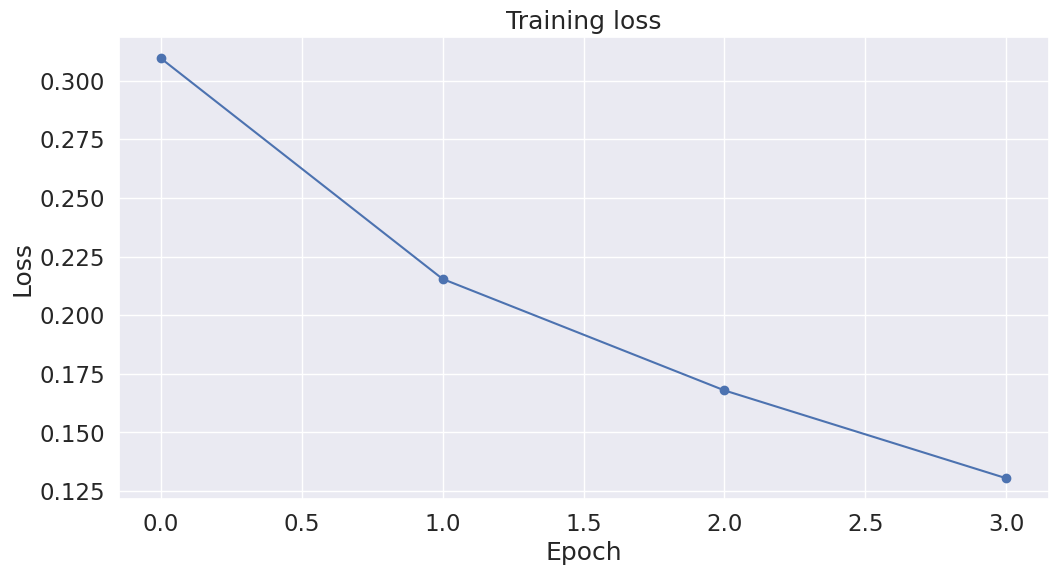

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Test Data Evaluation

In [ ]:
test_inputs, test_masks = bert_encode(tst_sentences,MAX_LEN)

prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

batch_size = 32
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,478 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('MCC: %.3f' % mcc)

MCC: 0.748


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.50      0.38      0.43       155
           1       0.93      0.95      0.94      1893
           2       0.90      0.89      0.90       430

    accuracy                           0.91      2478
   macro avg       0.78      0.74      0.76      2478
weighted avg       0.90      0.91      0.90      2478



# Sample Use

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer = tokenizer

def predict_sentence(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move to the same device as model

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()

    return prediction

sentence = "bitch"  # Replace with any sentence
prediction = predict_sentence(sentence, model, tokenizer)
print(f"Prediction: {prediction}")


Prediction: 1
